## Data Modeling and Prediction

Di notebook ini, akan saya lakukan data Modelling, Evaluation dan Prediction, dengan 4 jenis:

    1). baseline model, tidak ada over-sampling
    2). baseline model , ada over-sampling
    3). tuned model, tidak ada over-sampling
    4). tuned model, ada over-sampling
    
Modeling yang saya gunakan adalah:

    1). Logistic Regression
    2). K-Near Neighbors
    3). Random Forest
    
Cara hyperparameter tuning yang saya gunakan adalah : GridSearchCV
    
Evaluation Metrics saya akan gunakan:
    
    1). Precision (macro):
    Precision is defined as the number of true positives () over the number of true positives plus the number of false positives.
    
    2). recall (macro):
    Recall () is defined as the number of true positives () over the number of true positives plus the number of false negatives ().
    
    3). F1-score (macro):
    Which is defined as the harmonic mean of precision and recall.
    
    4). Matthew score:
    The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary and multiclass classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes.
    
    5. ROC / AUC score:
    The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.
    
NOTE: tapi keputusan terakhir utk memilih model terbaik adalah dengan melihat F1-score (macro), dikarenakan:

    1). F1 score adalah harmonic mean dari precision dan recall. F1-score is used when the False Negatives and False Positives are crucial, in which in this data set it is.
    2). Macro Average menghitung rata-rata suatu nilai tiap kelas, jadi tidak terpengaruh oleh imbalance class


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import kstest
from scipy.stats import mannwhitneyu, chi2_contingency
from yellowbrick.model_selection import LearningCurve

from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning.space import Real, Integer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from mlxtend.plotting import plot_learning_curves

import pickle

SEED = 21
import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported f

In [6]:
bank = pd.read_csv("/content/drive/My Drive/Final Project Purwadhika/bank_new.csv")

In [7]:
bank.head()

,age,job,marital,education,default,contact,month,campaign,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,telephone,may,1,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,telephone,may,1,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,telephone,may,1,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,telephone,may,1,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,telephone,may,1,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [8]:
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'contact', 'month',
       'campaign', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [9]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   contact         41188 non-null  object 
 6   month           41188 non-null  object 
 7   campaign        41188 non-null  int64  
 8   poutcome        41188 non-null  object 
 9   emp.var.rate    41188 non-null  float64
 10  cons.price.idx  41188 non-null  float64
 11  cons.conf.idx   41188 non-null  float64
 12  euribor3m       41188 non-null  float64
 13  nr.employed     41188 non-null  float64
 14  y               41188 non-null  object 
dtypes: float64(5), int64(2), object(8)
memory usage: 4.7+ MB


In [10]:
numcol = bank.select_dtypes(exclude = object).columns
catcol = bank.select_dtypes(exclude = np.number).columns.drop("y")
catData = bank.select_dtypes(exclude = np.number).columns

print(numcol)
print(catcol)
print(catData)

Index(['age', 'campaign', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed'],
      dtype='object')
Index(['job', 'marital', 'education', 'default', 'contact', 'month',
       'poutcome'],
      dtype='object')
Index(['job', 'marital', 'education', 'default', 'contact', 'month',
       'poutcome', 'y'],
      dtype='object')


## Normality Test

### Kolmogorov-Smirnov test

Ho (data is not significantly different from normal distribution)

H1 (data is significantly different from normal distribution).

In [11]:
# Normality test utk Numerical features

KS = []

for i in numcol:
    if kstest(bank[i], "norm")[1] < 0.05:
        KS.append("Reject Null Hypothesis")
    else:
        KS.append("Fail To reject Null Hypothesis")
        
pd.DataFrame({"Hypothesis" : KS}, index = numcol)

,Hypothesis
age,Reject Null Hypothesis
campaign,Reject Null Hypothesis
emp.var.rate,Reject Null Hypothesis
cons.price.idx,Reject Null Hypothesis
cons.conf.idx,Reject Null Hypothesis
euribor3m,Reject Null Hypothesis
nr.employed,Reject Null Hypothesis


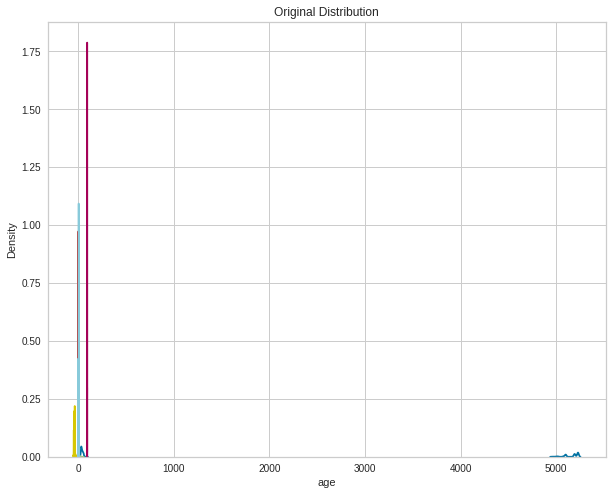

In [12]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Original Distribution')

sns.kdeplot(bank['age'], ax=ax1)
sns.kdeplot(bank['campaign'], ax=ax1)
sns.kdeplot(bank['emp.var.rate'], ax=ax1)
sns.kdeplot(bank['cons.price.idx'], ax=ax1)
sns.kdeplot(bank['cons.conf.idx'], ax=ax1)
sns.kdeplot(bank['euribor3m'], ax=ax1)
sns.kdeplot(bank['nr.employed'], ax=ax1);

### Significance Test


In [13]:
## significance test utk numerical features

mannwhit = []

for i in numcol:
    if mannwhitneyu(bank[bank["y"] == "no"][i],bank[bank["y"] == "yes"][i])[1] < 0.05:
        mannwhit.append("Reject Null Hypothesis")
    else:
        mannwhit.append("Fail To reject Null Hypothesis")

pd.DataFrame({"Hypothesis" : mannwhit}, index = numcol)

,Hypothesis
age,Reject Null Hypothesis
campaign,Reject Null Hypothesis
emp.var.rate,Reject Null Hypothesis
cons.price.idx,Reject Null Hypothesis
cons.conf.idx,Reject Null Hypothesis
euribor3m,Reject Null Hypothesis
nr.employed,Reject Null Hypothesis


In [14]:
# significance test utk categorical features

chi2 = []

for i in catcol:
    if chi2_contingency(pd.crosstab(bank["y"], bank[i]))[1] < 0.05:
        chi2.append("Reject Null Hypothesis")
    else:
        chi2.append("Fail To Reject Null Hypothesis")
        
pd.DataFrame({"Hypothesis" : chi2}, index = catcol)

,Hypothesis
job,Reject Null Hypothesis
marital,Reject Null Hypothesis
education,Reject Null Hypothesis
default,Reject Null Hypothesis
contact,Reject Null Hypothesis
month,Reject Null Hypothesis
poutcome,Reject Null Hypothesis


Features yang kita punya sekarang adalah features yang signifikan

## Train - Test Data Split

In [15]:
X = bank.drop("y", axis = 1)
y = bank["y"].map({"no" : 0, "yes" : 1})

In [16]:
y.unique()

array([0, 1])

In [17]:
X.columns

Index(['age', 'job', 'marital', 'education', 'default', 'contact', 'month',
       'campaign', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [18]:
numcol

Index(['age', 'campaign', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed'],
      dtype='object')

In [19]:
catcol

Index(['job', 'marital', 'education', 'default', 'contact', 'month',
       'poutcome'],
      dtype='object')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = SEED)

### Modeling 1 (Baseline Model) dan 2 (Baseline Model with SMOTE), saya akan menggunakan semua feature yang ada dan juga menggunanakan StandardScaler utk normalisation

## Pipeline Setup

In [21]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, ["emp.var.rate", "euribor3m", "nr.employed", "cons.price.idx", "cons.conf.idx", "age", "campaign"]),
        ("cat", categorical_transformer, ["month", "poutcome", "job", "marital", "education", "default", "contact"])])


## Modeling 1 (baseline model)

### LOGISTIC REGRESSION

In [22]:
log_model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('logreg', LogisticRegression(random_state = SEED))])

log_model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['emp.var.rate', 'euribor3m',
                                                   'nr.employed',
                                           

In [23]:
log_pred = log_model.predict(X_test)
log_pred

array([0, 0, 0, ..., 0, 0, 0])

In [24]:
log_proba = log_model.predict_proba(X_test)
log_proba

array([[0.78612372, 0.21387628],
       [0.96778699, 0.03221301],
       [0.96399414, 0.03600586],
       ...,
       [0.97419209, 0.02580791],
       [0.93189304, 0.06810696],
       [0.82093545, 0.17906455]])

### Evaluation

saya akan memakai macro average karena dia tidak melihat imbalance class data di target saya

In [25]:
print(classification_report(y_test,log_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10955
           1       0.66      0.21      0.32      1402

    accuracy                           0.90     12357
   macro avg       0.78      0.60      0.63     12357
weighted avg       0.88      0.90      0.87     12357



Confusion Matrix 



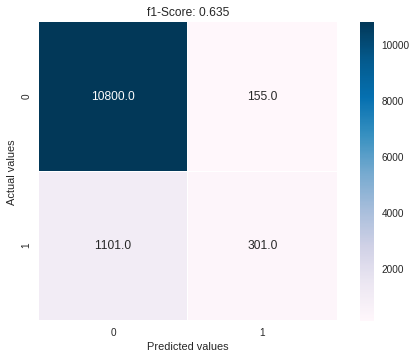

In [26]:
print("Confusion Matrix","\n")
score = round(f1_score(y_test, log_pred, average = "macro"),3) 
cm1 = confusion_matrix(y_test, log_pred)
sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = "PuBu")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.title("f1-Score: {0}".format(score), size = 12)
plt.show()
print("\n")

### Matthew Score

In [27]:
print("Matthew Score",matthews_corrcoef(y_test, log_pred))

Matthew Score 0.3373780432196273


AttributeError: ignored

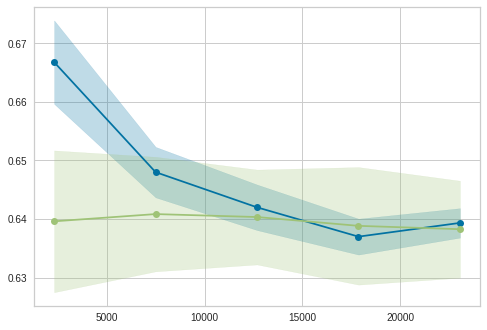

In [40]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    log_model, scoring = 'f1_macro', train_size = sizes, random_state = SEED, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

## K-Near Neighbors

In [28]:
knn_model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('knn', KNeighborsClassifier())])

knn_model.fit(X_train, y_train)  


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['emp.var.rate', 'euribor3m',
                                                   'nr.employed',
                                           

In [29]:
knn_pred = knn_model.predict(X_test)  

In [30]:
knn_proba = knn_model.predict_proba(X_test)
knn_proba

array([[0.8, 0.2],
       [1. , 0. ],
       [0.8, 0.2],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [0.8, 0.2]])

### Evaluation

In [31]:
print(classification_report(y_test,knn_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     10955
           1       0.51      0.29      0.37      1402

    accuracy                           0.89     12357
   macro avg       0.71      0.63      0.65     12357
weighted avg       0.87      0.89      0.87     12357



Confusion Matrix 



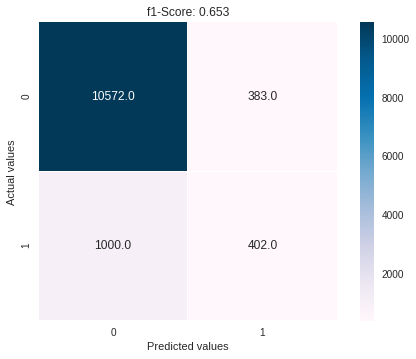

In [32]:
print("Confusion Matrix","\n")
score = round(f1_score(y_test, knn_pred, average = "macro"),3) 
cm1 = confusion_matrix(y_test, knn_pred)
sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = "PuBu")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.title("f1-Score: {0}".format(score), size = 12)
plt.show()
print("\n")

### Matthew Score

In [33]:
print("Matthew Score",matthews_corrcoef(y_test, knn_pred))

Matthew Score 0.3273773614879285


AttributeError: ignored

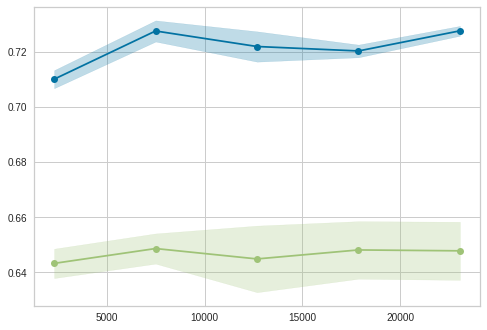

In [34]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    knn_model, scoring = 'f1_macro', train_size = sizes, random_state = SEED, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

## Random Forest

In [35]:
rfc_model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rfc', RandomForestClassifier(random_state = SEED))])

rfc_model.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['emp.var.rate', 'euribor3m',
                                                   'nr.employed',
                                           

In [36]:
rfc_pred = rfc_model.predict(X_test)

In [37]:
rfc_proba = rfc_model.predict_proba(X_test)
rfc_proba

array([[0.98, 0.02],
       [1.  , 0.  ],
       [0.68, 0.32],
       ...,
       [1.  , 0.  ],
       [0.94, 0.06],
       [0.95, 0.05]])

### Evaluation

In [38]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94     10955
           1       0.49      0.30      0.37      1402

    accuracy                           0.89     12357
   macro avg       0.70      0.63      0.65     12357
weighted avg       0.87      0.89      0.87     12357



Confusion Matrix 



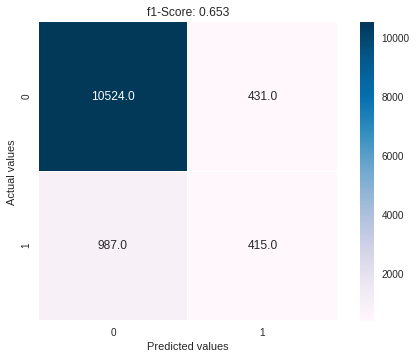

In [39]:
print("Confusion Matrix","\n")
score = round(f1_score(y_test, rfc_pred, average = "macro"),3) 
cm1 = confusion_matrix(y_test, rfc_pred)
sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = "PuBu")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.title("f1-Score: {0}".format(score), size = 12)
plt.show()
print("\n")

### Matthew Score

In [40]:
print("Matthew Score",matthews_corrcoef(y_test, rfc_pred))

Matthew Score 0.3223306874473393


AttributeError: ignored

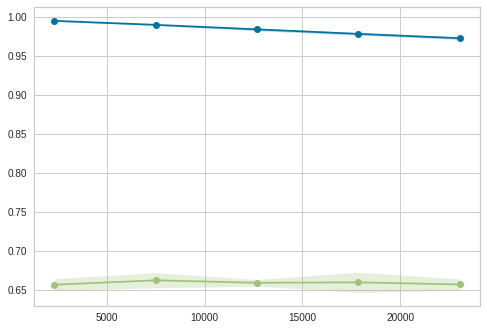

In [41]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    rfc_model, scoring = 'f1_macro', train_size = sizes, random_state = SEED, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

## Summary Report Modeling 1 (Baseline model)

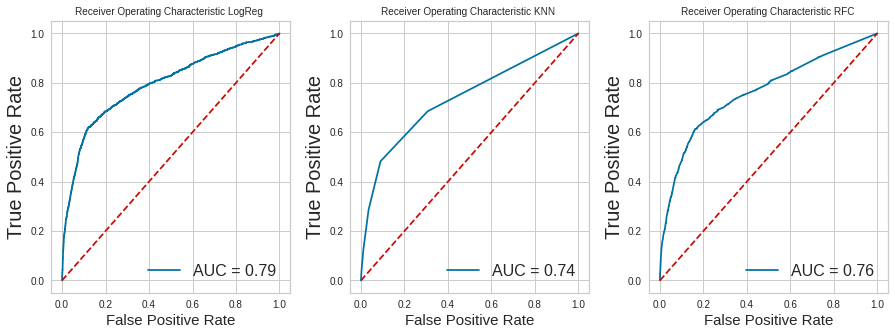

In [42]:
fig, (ax, ax1, ax2) = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))

## Logistic Regression
logpreds = log_proba[:,1]
fprlog, tprlog, thresholdlog = roc_curve(y_test, logpreds)
roc_auc_log = auc(fprlog, tprlog)

ax.plot(fprlog, tprlog, 'b', label = 'AUC = %0.2f' % roc_auc_log)
ax.plot([0, 1], [0, 1],'r--')
ax.set_title('Receiver Operating Characteristic LogReg ',fontsize=10)
ax.set_ylabel('True Positive Rate',fontsize=20)
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.legend(loc = 'lower right', prop={'size': 16})

## KNN
knnpreds = knn_proba[:,1]
fprknn, tprknn, thresholdknn = roc_curve(y_test, knnpreds)
roc_auc_knn = auc(fprknn, tprknn)

ax1.plot(fprknn, tprknn, 'b', label = 'AUC = %0.2f' % roc_auc_knn)
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_title('Receiver Operating Characteristic KNN ',fontsize=10)
ax1.set_ylabel('True Positive Rate',fontsize=20)
ax1.set_xlabel('False Positive Rate',fontsize=15)
ax1.legend(loc = 'lower right', prop={'size': 16})

## RFC
rfcpreds = rfc_proba[:,1]
fprrfc, tprrfc, thresholdrfc = roc_curve(y_test, rfcpreds)
roc_auc_rfc = auc(fprrfc, tprrfc)

ax2.plot(fprrfc, tprrfc, 'b', label = 'AUC = %0.2f' % roc_auc_rfc)
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_title('Receiver Operating Characteristic RFC ',fontsize=10)
ax2.set_ylabel('True Positive Rate',fontsize=20)
ax2.set_xlabel('False Positive Rate',fontsize=15)
ax2.legend(loc = 'lower right', prop={'size': 16})


plt.subplots_adjust(wspace=0.25)

In [43]:
def Metric_evaluation(y_test, y_pred):
    f1.append(f1_score(y_test,y_pred, average = 'macro'))
    precision.append(precision_score(y_test, y_pred, average = 'macro'))
    recall.append(recall_score(y_test, y_pred, average = 'macro'))
    matthews.append(matthews_corrcoef(y_test, y_pred)) 

def roc_auc(model):
    rocauc.append(model)

In [44]:
f1 = []
precision = []
recall = []
matthews = []
rocauc = []

In [45]:
Metric_evaluation(y_test, log_pred)
Metric_evaluation(y_test, knn_pred)
Metric_evaluation(y_test, rfc_pred)

roc_auc(roc_auc_log)
roc_auc(roc_auc_knn)
roc_auc(roc_auc_rfc)

In [46]:
Metric_table = pd.DataFrame(index = ['Base Logistic Regression',
                                             'Base K-Near Neighbors',
                                             'Base Random Forest Classifier'])

Metric_table['Macro F1-Score'] = f1
Metric_table['Macro Precision'] = precision
Metric_table['Macro Recall'] = recall
Metric_table['Matthews'] = matthews
Metric_table['ROC/AUC'] = rocauc

In [47]:
Metric_table

,Macro F1-Score,Macro Precision,Macro Recall,Matthews,ROC/AUC
Base Logistic Regression,0.634526,0.783787,0.600272,0.337378,0.794167
Base K-Near Neighbors,0.653117,0.712843,0.625886,0.327377,0.737392
Base Random Forest Classifier,0.653050,0.702400,0.628331,0.322331,0.761276


Utk Modeling 1, Random Forest Classifier lah juaranya kalau kita melihat dengan F1-Score

## Modeling 2 (Baseline model with SMOTE)

In [48]:
sm = SMOTE(random_state = SEED, sampling_strategy='minority')

### LOGISTIC REGRESSION SMOTE

In [49]:
log_model2 = Pipeline(steps=[('preprocessor', preprocessor), ('sm', sm),
                      ('logreg', LogisticRegression(random_state = SEED))])

log_model2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['emp.var.rate', 'euribor3m',
                                                   'nr.employed',
                                           

In [50]:
logsmote_pred = log_model2.predict(X_test)
logsmote_proba = log_model2.predict_proba(X_test)

In [51]:
print(classification_report(y_test,logsmote_pred))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89     10955
           1       0.34      0.66      0.44      1402

    accuracy                           0.81     12357
   macro avg       0.64      0.74      0.67     12357
weighted avg       0.88      0.81      0.84     12357



Confusion Matrix 



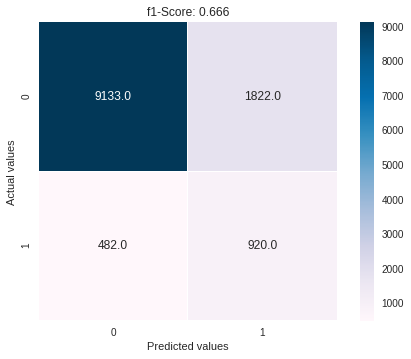

In [52]:
print("Confusion Matrix","\n")
score = round(f1_score(y_test, logsmote_pred, average = "macro"),3) 
cm1 = confusion_matrix(y_test, logsmote_pred)
sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = "PuBu")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.title("f1-Score: {0}".format(score), size = 12)
plt.show()
print("\n")

In [53]:
print("Matthew Score",matthews_corrcoef(y_test, logsmote_pred))

Matthew Score 0.3739118456966699


AttributeError: ignored

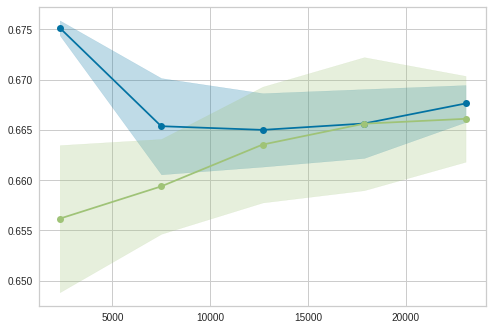

In [54]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    log_model2, scoring = 'f1_macro', train_size = sizes, random_state = SEED, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

## K-Near Neighbors SMOTE

In [55]:
knn_model2 = Pipeline(steps=[('preprocessor', preprocessor), ('sm', sm),
                      ('knn', KNeighborsClassifier())])

knn_model2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['emp.var.rate', 'euribor3m',
                                                   'nr.employed',
                                           

In [56]:
knnsmote_pred = knn_model2.predict(X_test)
knnsmote_proba = knn_model2.predict_proba(X_test)

In [57]:
print(classification_report(y_test,knnsmote_pred))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86     10955
           1       0.27      0.59      0.37      1402

    accuracy                           0.77     12357
   macro avg       0.60      0.69      0.61     12357
weighted avg       0.86      0.77      0.80     12357



Confusion Matrix 



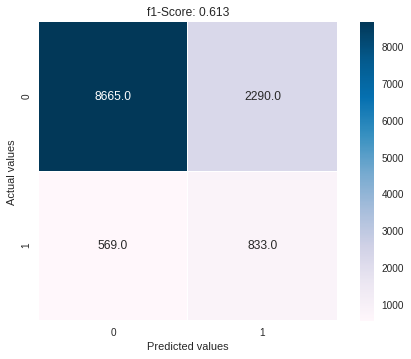

In [58]:
print("Confusion Matrix","\n")
score = round(f1_score(y_test, knnsmote_pred, average = "macro"),3) 
cm1 = confusion_matrix(y_test, knnsmote_pred)
sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = "PuBu")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.title("f1-Score: {0}".format(score), size = 12)
plt.show()
print("\n")

In [59]:
print("Matthew Score",matthews_corrcoef(y_test, knnsmote_pred))

Matthew Score 0.28105340518596245


AttributeError: ignored

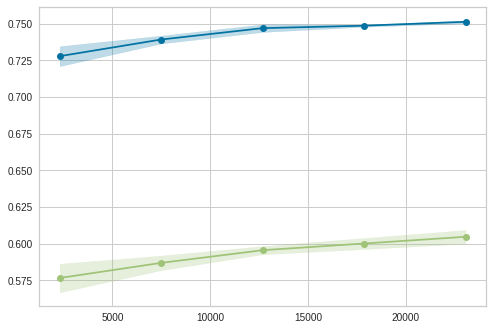

In [60]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    knn_model2, scoring = 'f1_macro', train_size = sizes, random_state = SEED, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

## Random Forest SMOTE

In [61]:
rfc_model2 = Pipeline(steps=[('preprocessor', preprocessor), ('sm', sm),
                      ('rfc', RandomForestClassifier(random_state = SEED))])

rfc_model2.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['emp.var.rate', 'euribor3m',
                                                   'nr.employed',
                                           

In [62]:
rfcsmote_pred = rfc_model2.predict(X_test)
rfcsmote_proba = rfc_model2.predict_proba(X_test)

In [63]:
print(classification_report(y_test,rfcsmote_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     10955
           1       0.43      0.37      0.40      1402

    accuracy                           0.87     12357
   macro avg       0.68      0.66      0.66     12357
weighted avg       0.87      0.87      0.87     12357



Confusion Matrix 



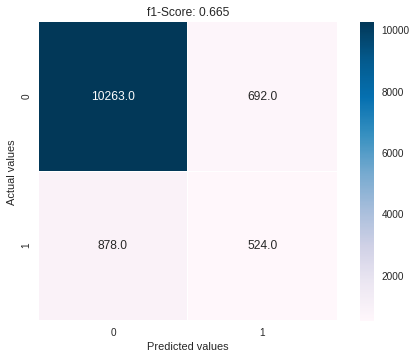

In [64]:
print("Confusion Matrix","\n")
score = round(f1_score(y_test, rfcsmote_pred, average = "macro"),3) 
cm1 = confusion_matrix(y_test, rfcsmote_pred)
sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = "PuBu")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.title("f1-Score: {0}".format(score), size = 12)
plt.show()
print("\n")

In [65]:
print("Matthew Score",matthews_corrcoef(y_test, rfcsmote_pred))

Matthew Score 0.33069740977634887


AttributeError: ignored

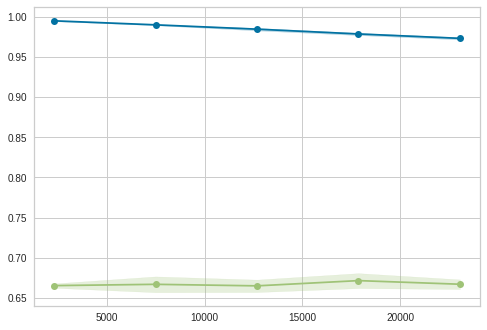

In [66]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    rfc_model2, scoring = 'f1_macro', train_size = sizes, random_state = SEED, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

## SUMMARY REPORT Modeling 1 (Baseline model) & Modeling 2 (Baseline with SMOTE)

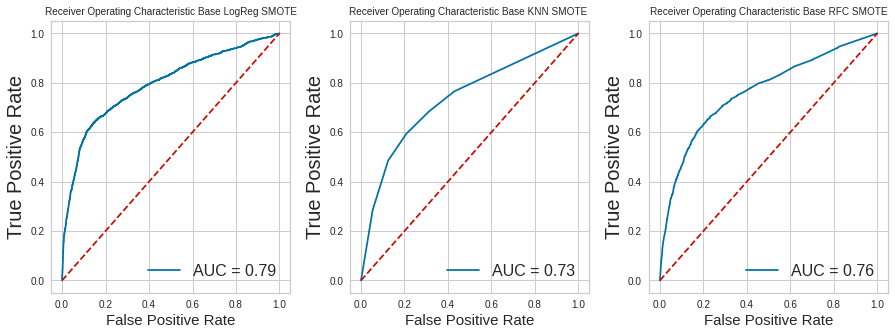

In [67]:
fig, (ax3, ax4, ax5) = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))

## Logistic Regression SMOTE
logpreds2 = logsmote_proba[:,1]
fprlog2, tprlog2, thresholdlog2 = roc_curve(y_test, logpreds2)
roc_auc_log2 = auc(fprlog2, tprlog2)

ax3.plot(fprlog2, tprlog2, 'b', label = 'AUC = %0.2f' % roc_auc_log2)
ax3.plot([0, 1], [0, 1],'r--')
ax3.set_title('Receiver Operating Characteristic Base LogReg SMOTE',fontsize=10)
ax3.set_ylabel('True Positive Rate',fontsize=20)
ax3.set_xlabel('False Positive Rate',fontsize=15)
ax3.legend(loc = 'lower right', prop={'size': 16})

## KNN
knnpreds2 = knnsmote_proba[:,1]
fprknn2, tprknn2, thresholdknn2 = roc_curve(y_test, knnpreds2)
roc_auc_knn2 = auc(fprknn2, tprknn2)

ax4.plot(fprknn2, tprknn2, 'b', label = 'AUC = %0.2f' % roc_auc_knn2)
ax4.plot([0, 1], [0, 1],'r--')
ax4.set_title('Receiver Operating Characteristic Base KNN SMOTE ',fontsize=10)
ax4.set_ylabel('True Positive Rate',fontsize=20)
ax4.set_xlabel('False Positive Rate',fontsize=15)
ax4.legend(loc = 'lower right', prop={'size': 16})

## RFC
rfcpred2 = rfcsmote_proba[:,1]
fprrfc2, tprrfc2, thresholdrfc2 = roc_curve(y_test, rfcpred2)
roc_auc_rfc2 = auc(fprrfc2, tprrfc2)

ax5.plot(fprrfc2, tprrfc2, 'b', label = 'AUC = %0.2f' % roc_auc_rfc2)
ax5.plot([0, 1], [0, 1],'r--')
ax5.set_title('Receiver Operating Characteristic Base RFC SMOTE',fontsize=10)
ax5.set_ylabel('True Positive Rate',fontsize=20)
ax5.set_xlabel('False Positive Rate',fontsize=15)
ax5.legend(loc = 'lower right', prop={'size': 16})


plt.subplots_adjust(wspace=0.25)

In [68]:
Metric_evaluation(y_test, logsmote_pred)
Metric_evaluation(y_test, knnsmote_pred)
Metric_evaluation(y_test, rfcsmote_pred)

roc_auc(roc_auc_log2)
roc_auc(roc_auc_knn2)
roc_auc(roc_auc_rfc2)

In [69]:
Metric_table = pd.DataFrame(index = ['Base Logistic Regression',
                                    'Base K-Near Neighbors',
                                    'Base Random Forest Classifier',
                                     'Base Logistic Regression SMOTE',
                                     'Base K-Near Neighbors SMOTE',
                                     'Base Random Forest Classifier SMOTE'
                                    ])

Metric_table['Macro F1-Score'] = f1
Metric_table['Macro Precision'] = precision
Metric_table['Macro Recall'] = recall
Metric_table['Matthews'] = matthews
Metric_table['ROC/AUC'] = rocauc

In [70]:
Metric_table

,Macro F1-Score,Macro Precision,Macro Recall,Matthews,ROC/AUC
Base Logistic Regression,0.634526,0.783787,0.600272,0.337378,0.794167
Base K-Near Neighbors,0.653117,0.712843,0.625886,0.327377,0.737392
Base Random Forest Classifier,0.653050,0.702400,0.628331,0.322331,0.761276
Base Logistic Regression SMOTE,0.666004,0.642696,0.744944,0.373912,0.793885
Base K-Near Neighbors SMOTE,0.613283,0.602555,0.692557,0.281053,0.734972
Base Random Forest Classifier SMOTE,0.664626,0.676057,0.655292,0.330697,0.763515


In [71]:
Final_Metric = pd.DataFrame({'Logistic Regression' : [f1[0],f1[3]],
                            'K-Near Neighbors' : [f1[1],f1[4]],
                            'Random Forest Classifier' : [f1[2],f1[5]]},
                            index = ['Base',
                                     'Base SMOTE'
                                    ])

In [72]:
Final_Metric

## utk melihat hasil F1-SCORE (MACRO)

,Logistic Regression,K-Near Neighbors,Random Forest Classifier
Base,0.634526,0.653117,0.653050
Base SMOTE,0.666004,0.613283,0.664626


### Modeling 3 (Tuned Model) dan 4 (Tuned Model with SMOTE), saya akan menggunakan feature selection dengan asumsi jika feature tsb mempunyai korelasi < 0.1 dengan target, maka akan saya drop.

## Feature Selection

In [73]:
## formula utk mencari correlasi antar categorical variables

#Correlation measurement untuk data kategorikal dan kategorical
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

#Correlation measurement untuk data kategorikal dan data numerikal
def correlation_ratio(categories, measurement):
    fcat,_ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurement[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array, y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurement,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

### Numerical Features Selection

In [74]:
numcol

Index(['age', 'campaign', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed'],
      dtype='object')

In [75]:
age_corr = []
camp_corr = []
emp_corr = []
price_corr = []
conf_corr = []
euri_corr = []
nr_corr = []

for col in catData:
        age_corr.append(correlation_ratio(bank[col],bank["age"]))
        camp_corr.append(correlation_ratio(bank[col],bank["campaign"]))
        emp_corr.append(correlation_ratio(bank[col],bank["emp.var.rate"]))
        price_corr.append(correlation_ratio(bank[col],bank["cons.price.idx"]))
        conf_corr.append(correlation_ratio(bank[col],bank["cons.conf.idx"]))
        euri_corr.append(correlation_ratio(bank[col],bank["euribor3m"]))
        nr_corr.append(correlation_ratio(bank[col],bank["nr.employed"]))
        
pd.DataFrame({"Corr_age" : age_corr, "Corr_campaign" : camp_corr, "Corr_emp.var.rate" : emp_corr, 
              "Corr_cons.price.idx" : price_corr, "Corr_cons.conf.idx" : conf_corr, "Corr_euribor3m" : euri_corr, 
              "Corr_nr.employed" : nr_corr
}, index = catData).loc[['y']]


,Corr_age,Corr_campaign,Corr_emp.var.rate,Corr_cons.price.idx,Corr_cons.conf.idx,Corr_euribor3m,Corr_nr.employed
y,0.030399,0.066357,0.298334,0.136211,0.054878,0.307771,0.354678


### Categorical Features Selection

In [76]:
catcol

Index(['job', 'marital', 'education', 'default', 'contact', 'month',
       'poutcome'],
      dtype='object')

In [77]:
job_cramers = []
marit_cramers = []
edu_cramers = []
def_cramers = []
cont_cramers = []
mon_cramers = []
pout_cramers = []

for col in catData:
        job_cramers.append(cramers_v(bank["job"],bank[col]))
        marit_cramers.append(cramers_v(bank["marital"],bank[col]))
        edu_cramers.append(cramers_v(bank["education"],bank[col]))
        def_cramers.append(cramers_v(bank["default"],bank[col]))
        cont_cramers.append(cramers_v(bank["contact"],bank[col]))
        mon_cramers.append(cramers_v(bank["month"],bank[col]))
        pout_cramers.append(cramers_v(bank["poutcome"],bank[col]))
        
pd.DataFrame({"CramersV_job" : job_cramers, "CramersV_marital" : marit_cramers, 
              "CramersV_education" : edu_cramers, "CramersV_default" : def_cramers, 
             "CramersV_contact" : cont_cramers, "CramersV_month" : mon_cramers, 
              "CramersV_poutcome" : pout_cramers
}, index = catData).loc[['y']]


,CramersV_job,CramersV_marital,CramersV_education,CramersV_default,CramersV_contact,CramersV_month,CramersV_poutcome
y,0.151893,0.053703,0.067236,0.099111,0.144611,0.274,0.320416


## Pipeline Setup 2

In [78]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor2 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, ["emp.var.rate", "euribor3m", "nr.employed", "cons.price.idx"]),
        ("cat", categorical_transformer, ["month", "poutcome", "job", "contact"])])


Feature social and economic hampir semua kecuali cons.conf.idx yang lumayan berpengaruh terhadap target variable.

## Modeling 3 (Tuned Model)

### Logistic Regression

In [79]:
logreg_params = {
    'logreg__fit_intercept': [True, False],
    'logreg__C': Real(low=-2, high=2, prior='log-uniform')
}

In [80]:
logreg = Pipeline(steps=[('preprocessor2', preprocessor2),
                      ('logreg', LogisticRegression(random_state = SEED))])

logreg_random = RandomizedSearchCV(estimator=logreg,param_distributions=logreg_params, scoring='f1_macro', cv = 5
                                  ,random_state = SEED, verbose = 1)


In [81]:
logreg_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   13.5s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor2',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scaler',
                                                                                                StandardScaler(copy=True,
                                                                                              

In [82]:
logreg_random.best_params_

{'logreg__C': 6.175781802732344, 'logreg__fit_intercept': False}

In [83]:
log_model3 = Pipeline(steps=[('preprocessor2', preprocessor2),
                      ('logreg', LogisticRegression(C = 6.175781802732344, fit_intercept = False, 
                                                    random_state = SEED))])
log_model3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor2',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['emp.var.rate', 'euribor3m',
                                                   'nr.employed',
                                          

In [84]:
#Prediksi menggunakan model baru
log_pred2 = log_model3.predict(X_test)
log_proba2 = log_model3.predict_proba(X_test)

In [85]:
print(classification_report(y_test,log_pred2))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10955
           1       0.66      0.22      0.33      1402

    accuracy                           0.90     12357
   macro avg       0.79      0.60      0.64     12357
weighted avg       0.88      0.90      0.87     12357



Confusion Matrix 



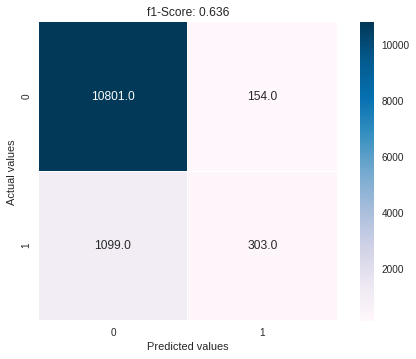

In [86]:
print("Confusion Matrix","\n")
score = round(f1_score(y_test, log_pred2, average = "macro"),3) 
cm1 = confusion_matrix(y_test, log_pred2)
sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = "PuBu")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.title("f1-Score: {0}".format(score), size = 12)
plt.show()
print("\n")

In [87]:
print("Matthew Score",matthews_corrcoef(y_test, log_pred2))

Matthew Score 0.33957362739982205


AttributeError: ignored

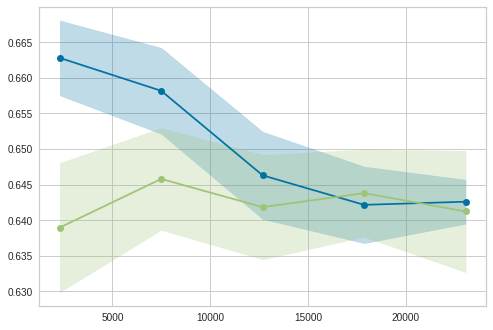

In [88]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    log_model3, scoring = 'f1_macro', train_size = sizes, random_state = SEED, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

## K-Near Neighbors

In [89]:
#List Hyperparameters that we want to tune.
knn_params = {
    'knn__n_neighbors': np.arange(1,31),
    'knn__weights': ["uniform","distance"]
}


In [90]:
#Create new KNN object
knn = Pipeline(steps=[('preprocessor2', preprocessor2),
                      ('knn', KNeighborsClassifier())])

knn_random = RandomizedSearchCV(estimator = knn, param_distributions = knn_params, scoring='f1_macro', cv = 5
                                  ,random_state = SEED, verbose = 1)


In [91]:
#Fit the model
knn_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor2',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scaler',
                                                                                                StandardScaler(copy=True,
                                                                                              

In [92]:
knn_random.best_params_

{'knn__n_neighbors': 15, 'knn__weights': 'uniform'}

In [93]:
knn_model3 = Pipeline(steps=[('preprocessor2', preprocessor2),
                      ('knn', KNeighborsClassifier(weights = 'uniform', n_neighbors = 15))])

knn_model3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor2',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['emp.var.rate', 'euribor3m',
                                                   'nr.employed',
                                          

In [94]:
knn_pred2 = knn_model3.predict(X_test)
knn_proba2 = knn_model3.predict_proba(X_test)

In [95]:
print(classification_report(y_test,knn_pred2))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     10955
           1       0.60      0.30      0.40      1402

    accuracy                           0.90     12357
   macro avg       0.76      0.64      0.67     12357
weighted avg       0.88      0.90      0.88     12357



Confusion Matrix 



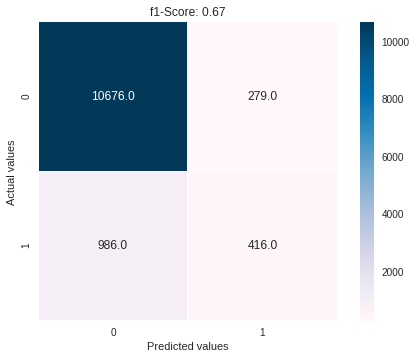

In [96]:
print("Confusion Matrix","\n")
score = round(f1_score(y_test, knn_pred2, average = "macro"),3) 
cm1 = confusion_matrix(y_test, knn_pred2)
sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = "PuBu")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.title("f1-Score: {0}".format(score), size = 12)
plt.show()
print("\n")

In [97]:
print("Matthew Score",matthews_corrcoef(y_test, knn_pred2))

Matthew Score 0.3733987545072714


AttributeError: ignored

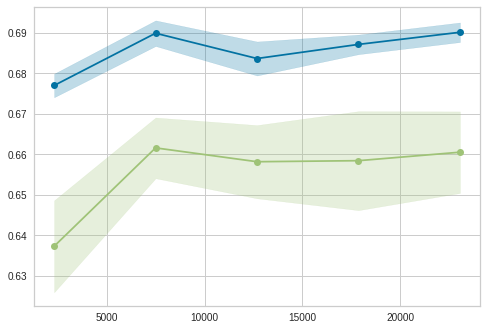

In [98]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    knn_model3, scoring = 'f1_macro', train_size = sizes, random_state = SEED, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

## Random Forest Classifier

In [99]:
rfc_params = {
    'rfc__n_estimators': Integer(low=150, high=250),
    'rfc__max_depth': Integer(low=10, high=40),
    'rfc__max_features': Real(low=0.1, high=1, prior='uniform'),
    'rfc__min_samples_leaf': Integer(low=1, high=18)
}



In [100]:
rfc = Pipeline(steps=[('preprocessor2', preprocessor2),
                      ('rfc', RandomForestClassifier(random_state = SEED))])

rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = rfc_params, 
                                scoring='f1_macro', cv = 5,random_state = SEED, verbose = 1)

In [101]:
rfc_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 18.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor2',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scaler',
                                                                                                StandardScaler(copy=True,
                                                                                              

In [102]:
rfc_random.best_params_

{'rfc__max_depth': 19,
 'rfc__max_features': 0.8193446819499037,
 'rfc__min_samples_leaf': 5,
 'rfc__n_estimators': 198}

In [104]:
rfc_model3 = Pipeline(steps=[('preprocessor2', preprocessor2),
                      ('rfc', RandomForestClassifier(max_depth = 19, 
                                                     max_features = 0.8193446819499037, 
                                                     min_samples_leaf = 5, 
                                                     n_estimators = 198, random_state = SEED))])

rfc_model3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor2',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['emp.var.rate', 'euribor3m',
                                                   'nr.employed',
                                          

In [105]:
rfc_pred2 = rfc_model3.predict(X_test)
rfc_proba2 = rfc_model3.predict_proba(X_test)

In [106]:
print(classification_report(y_test,rfc_pred2))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     10955
           1       0.60      0.29      0.39      1402

    accuracy                           0.90     12357
   macro avg       0.76      0.63      0.67     12357
weighted avg       0.88      0.90      0.88     12357



Confusion Matrix 



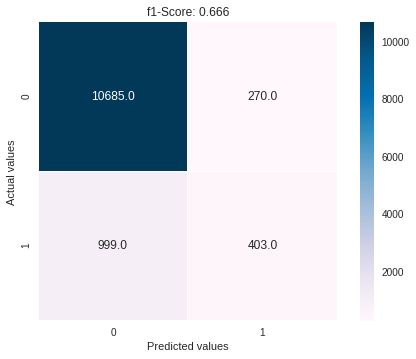

In [107]:
print("Confusion Matrix","\n")
score = round(f1_score(y_test, rfc_pred2, average = "macro"),3) 
cm1 = confusion_matrix(y_test, rfc_pred2)
sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = "PuBu")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.title("f1-Score: {0}".format(score), size = 12)
plt.show()
print("\n")

In [108]:
print("Matthew Score",matthews_corrcoef(y_test, rfc_pred2))

Matthew Score 0.3672845194593087


AttributeError: ignored

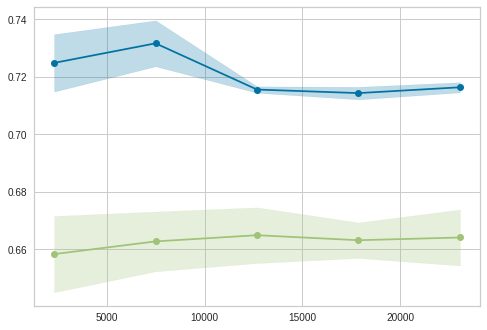

In [109]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    rfc_model3, scoring = 'f1_macro', train_size = sizes, random_state = SEED, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

## SUMMARY REPORT Modeling 1 (Baseline model), Modeling 2 (Baseline with SMOTE) & Modeling 3 (Tuned Model)

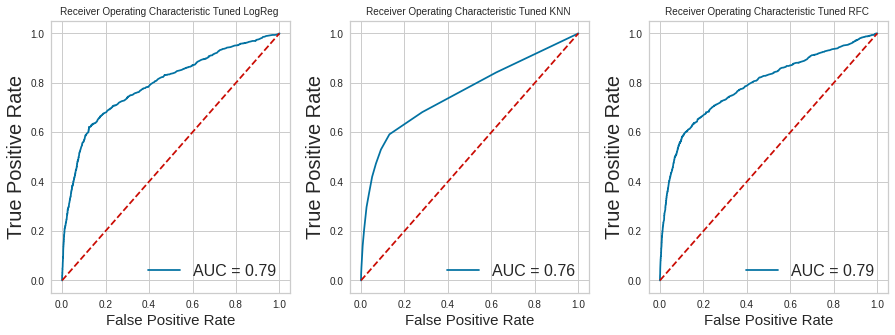

In [110]:
fig, (ax6, ax7, ax8) = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))

## Logistic Regression SMOTE
logpreds3 = log_proba2[:,1]
fprlog3, tprlog3, thresholdlog3 = roc_curve(y_test, logpreds3)
roc_auc_log3 = auc(fprlog3, tprlog3)

ax6.plot(fprlog3, tprlog3, 'b', label = 'AUC = %0.2f' % roc_auc_log3)
ax6.plot([0, 1], [0, 1],'r--')
ax6.set_title('Receiver Operating Characteristic Tuned LogReg ',fontsize=10)
ax6.set_ylabel('True Positive Rate',fontsize=20)
ax6.set_xlabel('False Positive Rate',fontsize=15)
ax6.legend(loc = 'lower right', prop={'size': 16})

## KNN
knnpreds3 = knn_proba2[:,1]
fprknn3, tprknn3, thresholdknn3 = roc_curve(y_test, knnpreds3)
roc_auc_knn3 = auc(fprknn3, tprknn3)

ax7.plot(fprknn3, tprknn3, 'b', label = 'AUC = %0.2f' % roc_auc_knn3)
ax7.plot([0, 1], [0, 1],'r--')
ax7.set_title('Receiver Operating Characteristic Tuned KNN ',fontsize=10)
ax7.set_ylabel('True Positive Rate',fontsize=20)
ax7.set_xlabel('False Positive Rate',fontsize=15)
ax7.legend(loc = 'lower right', prop={'size': 16})

## RFC
rfcpred3 = rfc_proba2[:,1]
fprrfc3, tprrfc3, thresholdrfc3 = roc_curve(y_test, rfcpred3)
roc_auc_rfc3 = auc(fprrfc3, tprrfc3)

ax8.plot(fprrfc3, tprrfc3, 'b', label = 'AUC = %0.2f' % roc_auc_rfc3)
ax8.plot([0, 1], [0, 1],'r--')
ax8.set_title('Receiver Operating Characteristic Tuned RFC ',fontsize=10)
ax8.set_ylabel('True Positive Rate',fontsize=20)
ax8.set_xlabel('False Positive Rate',fontsize=15)
ax8.legend(loc = 'lower right', prop={'size': 16})


plt.subplots_adjust(wspace=0.25)

In [111]:
Metric_evaluation(y_test, log_pred2)
Metric_evaluation(y_test, knn_pred2)
Metric_evaluation(y_test, rfc_pred2)

roc_auc(roc_auc_log3)
roc_auc(roc_auc_knn3)
roc_auc(roc_auc_rfc3)

In [112]:
f1
precision
recall
matthews
rocauc

[0.7941669363255597,
 0.7373919763837408,
 0.7612763535954048,
 0.7938852757129249,
 0.7349724036406229,
 0.7635149890194031,
 0.7937207783625272,
 0.7583025748572001,
 0.7902239481838229]

In [113]:
Metric_table = pd.DataFrame(index = ['Base Logistic Regression',
                                    'Base K-Near Neighbors',
                                    'Base Random Forest Classifier',
                                     'Base Logistic Regression SMOTE',
                                     'Base K-Near Neighbors SMOTE',
                                     'Base Random Forest Classifier SMOTE',
                                    'Tuned Logistic Regression',
                                    'Tuned K-Near Neighbors',
                                    'Tuned Random Forest Classifier'
                                    ])

Metric_table['Macro F1-Score'] = f1
Metric_table['Macro Precision'] = precision
Metric_table['Macro Recall'] = recall
Metric_table['Matthews'] = matthews
Metric_table['ROG/AUC'] = rocauc

In [114]:
Metric_table

,Macro F1-Score,Macro Precision,Macro Recall,Matthews,ROG/AUC
Base Logistic Regression,0.634526,0.783787,0.600272,0.337378,0.794167
Base K-Near Neighbors,0.653117,0.712843,0.625886,0.327377,0.737392
Base Random Forest Classifier,0.653050,0.702400,0.628331,0.322331,0.761276
Base Logistic Regression SMOTE,0.666004,0.642696,0.744944,0.373912,0.793885
Base K-Near Neighbors SMOTE,0.613283,0.602555,0.692557,0.281053,0.734972
Base Random Forest Classifier SMOTE,0.664626,0.676057,0.655292,0.330697,0.763515
Tuned Logistic Regression,0.635579,0.785333,0.601031,0.339574,0.793721
Tuned K-Near Neighbors,0.670413,0.757007,0.635626,0.373399,0.758303
Tuned Random Forest Classifier,0.666190,0.756655,0.631400,0.367285,0.790224


## Modeling 4 (Tuned Model with SMOTE)

## Logistic Regression

In [115]:
#List Hyperparameters yang akan diuji
logreg_smote_params = {
    'logreg__fit_intercept': [True, False],
    'logreg__C': Real(low=-2, high=2, prior='log-uniform')
}


In [116]:
logreg_smote = Pipeline(steps=[('preprocessor2', preprocessor2), ('sm', sm),
                      ('logreg', LogisticRegression(random_state = SEED))])

logreg_smote_random = RandomizedSearchCV(estimator=logreg_smote,param_distributions=logreg_smote_params, scoring='f1_macro', cv = 5
                                  ,random_state = SEED, verbose = 1)



In [117]:
logreg_smote_random.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 12.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor2',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scaler',
                                                                                                StandardScaler(copy=True,
                                                                                              

In [118]:
logreg_smote_random.best_params_

{'logreg__C': 6.175781802732344, 'logreg__fit_intercept': False}

In [119]:
log_model4 = Pipeline(steps=[('preprocessor2', preprocessor2), ('sm', sm),
                      ('logreg', LogisticRegression(C = 6.175781802732344, fit_intercept = False, 
                                                    random_state = SEED))])

log_model4.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('preprocessor2',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['emp.var.rate', 'euribor3m',
                                                   'nr.employed',
                                          

In [120]:
#Prediksi menggunakan model baru
logsmote_pred2 = log_model4.predict(X_test)
logsmote_proba2 = log_model4.predict_proba(X_test)

In [121]:
print(classification_report(y_test,logsmote_pred2))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89     10955
           1       0.33      0.65      0.44      1402

    accuracy                           0.81     12357
   macro avg       0.64      0.74      0.66     12357
weighted avg       0.88      0.81      0.84     12357



Confusion Matrix 



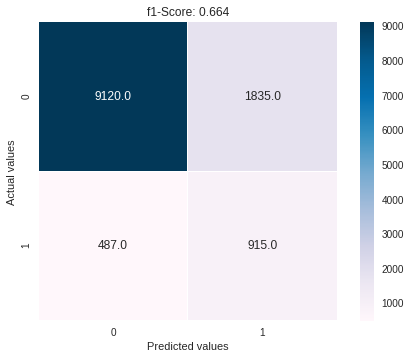

In [122]:
print("Confusion Matrix","\n")
score = round(f1_score(y_test, logsmote_pred2, average = "macro"),3) 
cm1 = confusion_matrix(y_test, logsmote_pred2)
sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = "PuBu")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.title("f1-Score: {0}".format(score), size = 12)
plt.show()
print("\n")

In [123]:
print("Matthew Score",matthews_corrcoef(y_test, logsmote_pred2))

Matthew Score 0.36989900041792806


AttributeError: ignored

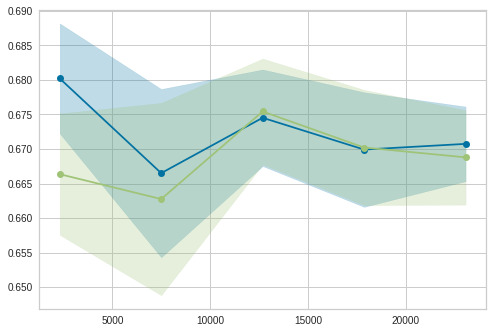

In [124]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    log_model4, scoring = 'f1_macro', train_size = sizes, random_state = SEED, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

## K-Near Neighbors

In [125]:
#List Hyperparameters that we want to tune.
knn_smote_params = {
    'knn__n_neighbors': np.arange(1,31),
    'knn__weights': ["uniform","distance"]
}


In [126]:
knn_smote = Pipeline(steps=[('preprocessor2', preprocessor2), ('sm', sm),
                      ('knn', KNeighborsClassifier())])

knn_smote_random = RandomizedSearchCV(estimator=knn_smote,param_distributions=knn_smote_params, scoring='f1_macro', cv = 5
                                  ,random_state = SEED, verbose = 1)



In [127]:
knn_smote_random.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 19.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor2',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scaler',
                                                                                                StandardScaler(copy=True,
                                                                                              

In [128]:
knn_smote_random.best_params_

{'knn__n_neighbors': 12, 'knn__weights': 'uniform'}

In [129]:
knn_model4 = Pipeline(steps=[('preprocessor2', preprocessor2), ('sm', sm),
                      ('knn', KNeighborsClassifier(n_neighbors = 12, weights = 'uniform'))])

knn_model4.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('preprocessor2',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['emp.var.rate', 'euribor3m',
                                                   'nr.employed',
                                          

In [130]:
knnsmote_pred2 = knn_model4.predict(X_test)
knnsmote_proba2 = knn_model4.predict_proba(X_test)

In [131]:
print(classification_report(y_test,knnsmote_pred2))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89     10955
           1       0.33      0.58      0.42      1402

    accuracy                           0.82     12357
   macro avg       0.63      0.71      0.65     12357
weighted avg       0.87      0.82      0.84     12357



Confusion Matrix 



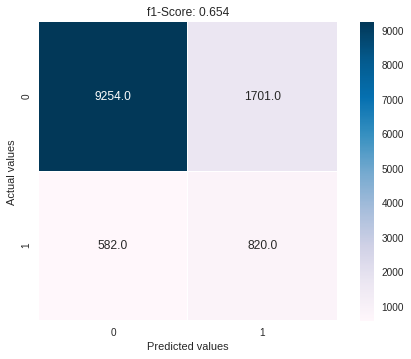

In [132]:
print("Confusion Matrix","\n")
score = round(f1_score(y_test, knnsmote_pred2, average = "macro"),3) 
cm1 = confusion_matrix(y_test, knnsmote_pred2)
sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = "PuBu")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.title("f1-Score: {0}".format(score), size = 12)
plt.show()
print("\n")

In [133]:
print("Matthew Score",matthews_corrcoef(y_test, knnsmote_pred2))

Matthew Score 0.33810846584144266


AttributeError: ignored

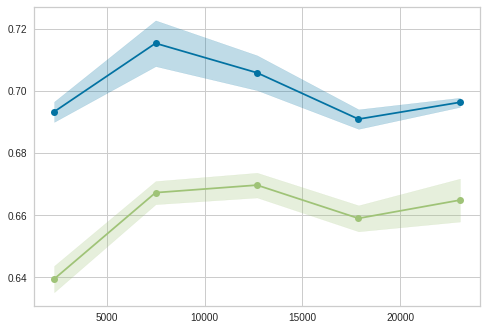

In [134]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    knn_model4, scoring = 'f1_macro', train_size = sizes, random_state = SEED, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

## Random Forest Classifier

In [135]:
#List Hyperparameters that we want to tune.
rfc_smote_params = {
    'rfc__n_estimators': Integer(low=150, high=250),
    'rfc__max_depth': Integer(low=10, high=40),
    'rfc__max_features': Real(low=0.1, high=1, prior='uniform'),
    'rfc__min_samples_leaf': Integer(low=1, high=18)
}


In [136]:
rfc_smote = Pipeline(steps=[('preprocessor2', preprocessor2), ('sm', sm),
                      ('rfc', RandomForestClassifier(random_state = SEED))])

rfc_smote_random = RandomizedSearchCV(estimator=rfc_smote,param_distributions=rfc_smote_params, scoring='f1_macro', cv = 5
                                  ,random_state = SEED, verbose = 1)



In [137]:
rfc_smote_random.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 58.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor2',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scaler',
                                                                                                StandardScaler(copy=True,
                                                                                              

In [138]:
rfc_smote_random.best_params_

{'rfc__max_depth': 26,
 'rfc__max_features': 0.17665492049472825,
 'rfc__min_samples_leaf': 7,
 'rfc__n_estimators': 234}

In [139]:
rfc_model4 = Pipeline(steps=[('preprocessor2', preprocessor2), ('sm', sm),
                      ('rfc', RandomForestClassifier(max_depth = 26, max_features = 0.17665492049472825, 
                                                     min_samples_leaf = 7, n_estimators = 234, random_state = SEED))])

rfc_model4.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('preprocessor2',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['emp.var.rate', 'euribor3m',
                                                   'nr.employed',
                                          

In [140]:
rfcsmote_pred2 = rfc_model4.predict(X_test)
rfcsmote_proba2 = rfc_model4.predict_proba(X_test)

In [141]:
print(classification_report(y_test,rfcsmote_pred2))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91     10955
           1       0.38      0.61      0.47      1402

    accuracy                           0.84     12357
   macro avg       0.67      0.74      0.69     12357
weighted avg       0.88      0.84      0.86     12357



Confusion Matrix 



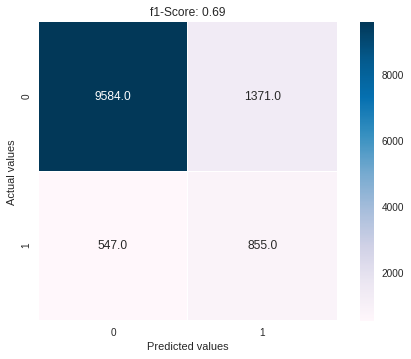

In [142]:
print("Confusion Matrix","\n")
score = round(f1_score(y_test, rfcsmote_pred2, average = "macro"),3) 
cm1 = confusion_matrix(y_test, rfcsmote_pred2)
sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = "PuBu")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.title("f1-Score: {0}".format(score), size = 12)
plt.show()
print("\n")

In [143]:
print("Matthew Score",matthews_corrcoef(y_test, rfcsmote_pred2))

Matthew Score 0.3999997991485046


AttributeError: ignored

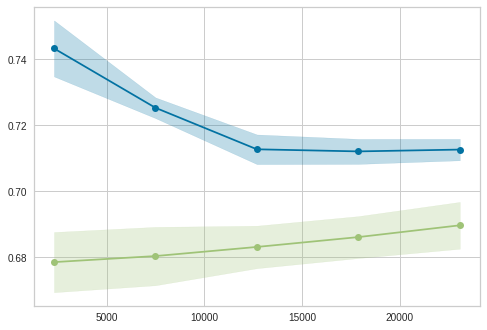

In [144]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    rfc_model4, scoring = 'f1_macro', train_size = sizes, random_state = SEED, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

## SUMMARY REPORT Modeling 1 (Baseline model), Modeling 2 (Baseline with SMOTE), Modeling 3 (Tuned Model) & Modeling 4 (Tuned model with SMOTE)

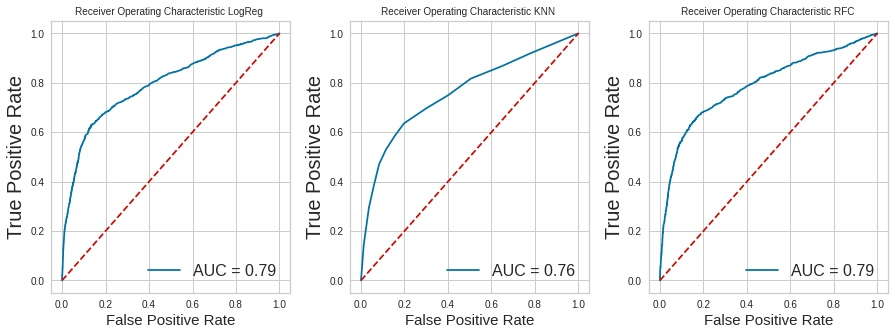

In [145]:
fig, (ax9, ax10, ax11) = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))

## Logistic Regression SMOTE
logpreds4 = logsmote_proba2[:,1]
fprlog4, tprlog4, thresholdlog4 = roc_curve(y_test, logpreds4)
roc_auc_log4 = auc(fprlog4, tprlog4)

ax9.plot(fprlog4, tprlog4, 'b', label = 'AUC = %0.2f' % roc_auc_log4)
ax9.plot([0, 1], [0, 1],'r--')
ax9.set_title('Receiver Operating Characteristic LogReg ',fontsize=10)
ax9.set_ylabel('True Positive Rate',fontsize=20)
ax9.set_xlabel('False Positive Rate',fontsize=15)
ax9.legend(loc = 'lower right', prop={'size': 16})

## KNN
knnpreds4 = knnsmote_proba2[:,1]
fprknn4, tprknn4, thresholdknn4 = roc_curve(y_test, knnpreds4)
roc_auc_knn4 = auc(fprknn4, tprknn4)

ax10.plot(fprknn4, tprknn4, 'b', label = 'AUC = %0.2f' % roc_auc_knn4)
ax10.plot([0, 1], [0, 1],'r--')
ax10.set_title('Receiver Operating Characteristic KNN ',fontsize=10)
ax10.set_ylabel('True Positive Rate',fontsize=20)
ax10.set_xlabel('False Positive Rate',fontsize=15)
ax10.legend(loc = 'lower right', prop={'size': 16})

## RFC
rfcpred4 = rfcsmote_proba2[:,1]
fprrfc4, tprrfc4, thresholdrfc4 = roc_curve(y_test, rfcpred4)
roc_auc_rfc4 = auc(fprrfc4, tprrfc4)

ax11.plot(fprrfc4, tprrfc4, 'b', label = 'AUC = %0.2f' % roc_auc_rfc4)
ax11.plot([0, 1], [0, 1],'r--')
ax11.set_title('Receiver Operating Characteristic RFC ',fontsize=10)
ax11.set_ylabel('True Positive Rate',fontsize=20)
ax11.set_xlabel('False Positive Rate',fontsize=15)
ax11.legend(loc = 'lower right', prop={'size': 16})


plt.subplots_adjust(wspace=0.25)

In [146]:
Metric_evaluation(y_test, logsmote_pred2)
Metric_evaluation(y_test, knnsmote_pred2)
Metric_evaluation(y_test, rfcsmote_pred2)

roc_auc(roc_auc_log4)
roc_auc(roc_auc_knn4)
roc_auc(roc_auc_rfc4)

In [147]:
Metric_table = pd.DataFrame(index = ['Base Logistic Regression',
                                    'Base K-Near Neighbors',
                                    'Base Random Forest Classifier',
                                     'Base Logistic Regression SMOTE',
                                     'Base K-Near Neighbors SMOTE',
                                     'Base Random Forest Classifier SMOTE',
                                    'Tuned Logistic Regression',
                                    'Tuned K-Near Neighbors',
                                    'Tuned Random Forest Classifier',
                                     'Tuned Logistic Regression SMOTE',
                                    'Tuned K-Near Neighbors SMOTE',
                                    'Tuned Random Forest Classifier SMOTE'
                                    ])

Metric_table['Macro F1-Score'] = f1
Metric_table['Macro Precision'] = precision
Metric_table['Macro Recall'] = recall
Metric_table['Matthews'] = matthews
Metric_table['ROG/AUC'] = rocauc

In [148]:
Metric_table

,Macro F1-Score,Macro Precision,Macro Recall,Matthews,ROG/AUC
Base Logistic Regression,0.634526,0.783787,0.600272,0.337378,0.794167
Base K-Near Neighbors,0.653117,0.712843,0.625886,0.327377,0.737392
Base Random Forest Classifier,0.653050,0.702400,0.628331,0.322331,0.761276
Base Logistic Regression SMOTE,0.666004,0.642696,0.744944,0.373912,0.793885
Base K-Near Neighbors SMOTE,0.613283,0.602555,0.692557,0.281053,0.734972
Base Random Forest Classifier SMOTE,0.664626,0.676057,0.655292,0.330697,0.763515
Tuned Logistic Regression,0.635579,0.785333,0.601031,0.339574,0.793721
Tuned K-Near Neighbors,0.670413,0.757007,0.635626,0.373399,0.758303
Tuned Random Forest Classifier,0.666190,0.756655,0.631400,0.367285,0.790224
Tuned Logistic Regression SMOTE,0.663912,0.641018,0.742568,0.369899,0.793790


In [149]:
Final_Metric = pd.DataFrame({'Logistic Regression' : [f1[0],f1[3],f1[6],f1[9]],
                            'K-Near Neighbors' : [f1[1],f1[4],f1[7],f1[10]],
                            'Random Forest Classifier' : [f1[2],f1[5],f1[8],f1[11]]},
                            index = ['Base',
                                     'Base SMOTE',
                                     'Tuned',
                                     'Tuned SMOTE'
                                    ])

In [150]:
Final_Metric

,Logistic Regression,K-Near Neighbors,Random Forest Classifier
Base,0.634526,0.653117,0.653050
Base SMOTE,0.666004,0.613283,0.664626
Tuned,0.635579,0.670413,0.666190
Tuned SMOTE,0.663912,0.654120,0.690187


Dari sini, saya simpulkan bahwa:
    
    
        1). jika saya ingin melihat precision score, maka model Tuned Logistic Regression lah yang 
            paling bagus scorenya
        2). jika utk F1-score, yang terbaik adalah dari Tuned Random Forest Classifier Smote